Dataset: **Sleep-EDF Expanded**  
https://physionet.org/content/sleep-edfx/1.0.0/

In [1]:
# !pip install mne pyedflib seglearn tsfel tsfresh antropy plotly-resampler tsflex powershap --upgrade

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys

sys.path.append("../../src/")

In [4]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load data

In [5]:
df_feats = pd.read_parquet("../../features/sleep-edf__cassette_features_ALL__90s.parquet")
df_feats.shape

(416271, 366)

In [6]:
df_feats["label"].value_counts()

Sleep stage W    285286
Sleep stage 2     69132
Sleep stage R     25835
Sleep stage 1     21521
Sleep stage 3      8793
Sleep stage 4      4246
Sleep stage ?      1330
Movement time       128
Name: label, dtype: int64

In [7]:
df_feats.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 416271 entries, 1989-04-24 16:13:00 to 1991-09-27 14:24:00
Columns: 366 entries, EEG Fpz-Cz__TotalAbsPow__w=1m30s_s=30s to patient_id
dtypes: float32(363), object(3)
memory usage: 589.1+ MB


In [8]:
sigs = list(set(c.split("__")[0] for c in df_feats.columns))
eeg_signals = [d for d in sigs if "EEG" in d]
bands = ["alpha", "beta", "sdelta", "fdelta", "sigma", "theta"]
for eeg_sig in eeg_signals:
    eeg_bands = [c for c in df_feats.columns if c.startswith(eeg_sig) and c.split("__")[1] in bands]
    windows = sorted(set(b.split("__")[-1] for b in eeg_bands))
    for window in windows:
        # Select the spectral powers
        delta = df_feats["__".join([eeg_sig, "sdelta", window])] + df_feats["__".join([eeg_sig, "fdelta", window])]
        fdelta_theta = df_feats["__".join([eeg_sig, "fdelta", window])] + df_feats["__".join([eeg_sig, "theta", window])]
        alpha = df_feats["__".join([eeg_sig, "alpha", window])]
        beta = df_feats["__".join([eeg_sig, "beta", window])]
        theta = df_feats["__".join([eeg_sig, "theta", window])]
        sigma = df_feats["__".join([eeg_sig, "sigma", window])]
        # Calculate the ratios
        df_feats["__".join([eeg_sig, "fdelta+theta", window])] = fdelta_theta.astype("float32")        

        df_feats["__".join([eeg_sig, "alpha/theta", window])] = (alpha / theta).astype("float32")
        df_feats["__".join([eeg_sig, "delta/beta", window])] = (delta / beta).astype("float32")
        df_feats["__".join([eeg_sig, "delta/sigma", window])] = (delta / sigma).astype("float32")
        df_feats["__".join([eeg_sig, "delta/theta", window])] = (delta / theta).astype("float32")
df_feats.shape

(416271, 396)

In [9]:
skip_cols = ["psg_file", "label", "patient_id"]
feat_cols = [c for c in df_feats.columns if c not in skip_cols]

In [10]:
# Add the 30s features from the minute before and the minute after the epoch (= current sample of 30s) to the epoch
feats_30s = [f for f in df_feats.columns if "w=30s" in f]
feats_60s = [f for f in df_feats.columns if "w=1m_" in f]
feats_90s = [f for f in df_feats.columns if "w=1m30s" in f]
print(len(feats_30s), len(feats_60s), len(feats_90s))
dfs = []
for psg_file in df_feats.psg_file.unique():
    sub_df = df_feats[df_feats.psg_file == psg_file]

    sub_df = sub_df.merge(
        sub_df[feats_90s].shift(1).add_suffix("_shift=30s"),
        left_index=True,
        right_index=True,
    )
    sub_df = sub_df.drop(columns=feats_90s)

    sub_df = sub_df.merge(
        sub_df[feats_60s].shift(1).add_suffix("_shift=30s"),
        left_index=True,
        right_index=True,
    )

    sub_df = sub_df.merge(sub_df[feats_30s].shift(2).add_suffix("_shift=1m"), left_index=True, right_index=True)
    sub_df = sub_df.merge(sub_df[feats_30s].shift(1).add_suffix("_shift=30s"), left_index=True, right_index=True)
    sub_df = sub_df.merge(sub_df[feats_30s].shift(-1).add_suffix("_shift=-30s"), left_index=True, right_index=True)
    sub_df = sub_df.merge(sub_df[feats_30s].shift(-2).add_suffix("_shift=-1m"), left_index=True, right_index=True)
    dfs += [sub_df]
df_feats = pd.concat(dfs)
df_feats.shape

131 131 131


(416271, 1051)

In [11]:
df_feats.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 416271 entries, 1989-04-24 16:13:00 to 1991-09-27 14:24:00
Columns: 1051 entries, EEG Fpz-Cz__TotalAbsPow__w=1m_s=30s to EEG Fpz-Cz__delta/theta__w=30s_s=30s_shift=-1m
dtypes: float32(1048), object(3)
memory usage: 1.6+ GB


In [12]:
# Postprocess labels
df_feats.loc[df_feats["label"] == "Sleep stage 4", "label"] = "Sleep stage 3"
df_feats = df_feats[df_feats["label"] != "Movement time"]
df_feats = df_feats[df_feats["label"] != "Sleep stage ?"]  # Label that is given when recording is done / end of the night

df_feats = df_feats[~df_feats["label"].isna()]

In [13]:
# Trimming for all data
def get_repeat_length(val, arr):
    if arr[0] != val:
        return 0
    return np.where(arr != val)[0][0] + 1


dfs = []
for psg_file in df_feats["psg_file"].unique():
    sub_df = df_feats[df_feats.psg_file == psg_file]  # .sort_index()
    labels = sub_df["label"].values
    nb_wake_before_sleep = get_repeat_length("Sleep stage W", labels)
    nb_wake_after_sleep = get_repeat_length("Sleep stage W", labels[::-1])
    start_idx = max(0, nb_wake_before_sleep - 30 * 2)
    end_idx = min(-1, -nb_wake_after_sleep + 30 * 2)
    dfs.append(sub_df[start_idx:end_idx])
df_feats = pd.concat(dfs)
del dfs



In [14]:
# Trimming for SC-20

sc20_patients = [
    "SC400",
    "SC401",
    "SC402",
    "SC403",
    "SC404",
    "SC405",
    "SC406",
    "SC407",
    "SC408",
    "SC409",
    "SC410",
    "SC411",
    "SC412",
    "SC413",
    "SC414",
    "SC415",
    "SC416",
    "SC417",
    "SC418",
    "SC419",
]

df_feats_sc20 = df_feats[df_feats.patient_id.isin(sc20_patients)]

In [15]:
# Label stats for the SC-EDF-20 data
print(len(df_feats_sc20))
df_feats_sc20["label"].value_counts()

42230


Sleep stage 2    17799
Sleep stage W     8207
Sleep stage R     7717
Sleep stage 3     5703
Sleep stage 1     2804
Name: label, dtype: int64

In [16]:
# Label stats for the SC-EDF-78 data
print(len(df_feats))
df_feats["label"].value_counts()

195168


Sleep stage 2    69132
Sleep stage W    65642
Sleep stage R    25835
Sleep stage 1    21520
Sleep stage 3    13039
Name: label, dtype: int64

In [17]:
skip_cols = ["psg_file", "label", "patient_id"]
feat_cols = [c for c in df_feats.columns if c not in skip_cols]
len(feat_cols)

1048

In [18]:
classes = [
    'Sleep stage W',
    'Sleep stage 1',
    'Sleep stage 2',
    'Sleep stage 3',
    'Sleep stage R'
]

# ML

In [19]:
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    cohen_kappa_score,
    log_loss,
)
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer

from sklearn.linear_model import SGDClassifier

In [20]:
from visualizations import plot_linear_classification_coefs
from visualizations import plot_learning_curve
from visualizations import plot_confusion_matrix

## The simple, linear pipeline

In [21]:
### Create pipeline
pipe = Pipeline(
    [
        ("impute", SimpleImputer()),
        ("scale", QuantileTransformer(n_quantiles=100, subsample=200_000, random_state=0)),
        (
            "linear_model",
            SGDClassifier(
                loss="log",
                average=True,
                class_weight="balanced",
                n_jobs=5,
                random_state=0,
            ),
        ),
    ]
)

### Grouped 20-fold results for SC-20 for varying inputs

---------------------------------------- ['EEG'] ----------------------------------------
nb. features = 592
10-FOLD: TRAIN
  MACRO F1:           0.8232
  Balanced accuracy:  0.8317
  Accuracy:           0.872
  Log loss:           0.5548
10-FOLD: TEST
  MACRO F1:           0.7735
  Balanced accuracy:  0.7975
  Accuracy:           0.8385
  Log loss:           0.8042

F1: 0.7798599100032391
ACC: 0.8386928723656168
KAPPA: 0.7808645492819415
LOG LOSS: 0.80455140999726

               precision    recall  f1-score   support

Sleep stage 1       0.46      0.40      0.43      3195
Sleep stage 2       0.85      0.90      0.88     16777
Sleep stage 3       0.92      0.84      0.88      6230
Sleep stage R       0.86      0.81      0.83      8213
Sleep stage W       0.87      0.91      0.89      7815

     accuracy                           0.84     42230
    macro avg       0.79      0.77      0.78     42230
 weighted avg       0.84      0.84      0.84     42230



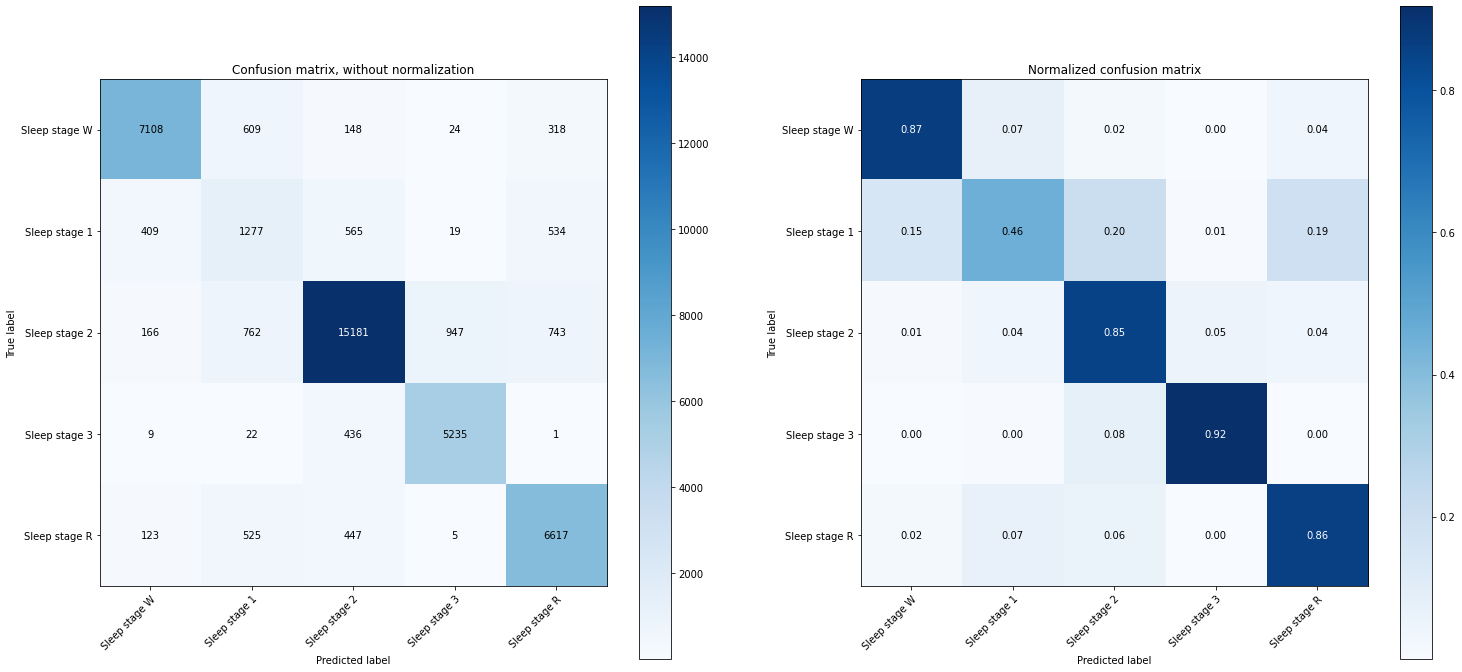





---------------------------------------- ['EEG', 'EOG'] ----------------------------------------
nb. features = 848
10-FOLD: TRAIN
  MACRO F1:           0.8432
  Balanced accuracy:  0.8545
  Accuracy:           0.884
  Log loss:           0.5612
10-FOLD: TEST
  MACRO F1:           0.7926
  Balanced accuracy:  0.8195
  Accuracy:           0.8531
  Log loss:           0.8617

F1: 0.8029578564471864
ACC: 0.8533033388586313
KAPPA: 0.8006141057055653
LOG LOSS: 0.8653259886893605

               precision    recall  f1-score   support

Sleep stage 1       0.53      0.46      0.49      3258
Sleep stage 2       0.86      0.90      0.88     16873
Sleep stage 3       0.91      0.84      0.87      6238
Sleep stage R       0.89      0.85      0.87      8030
Sleep stage W       0.88      0.92      0.90      7831

     accuracy                           0.85     42230
    macro avg       0.81      0.79      0.80     42230
 weighted avg       0.85      0.85      0.85     42230



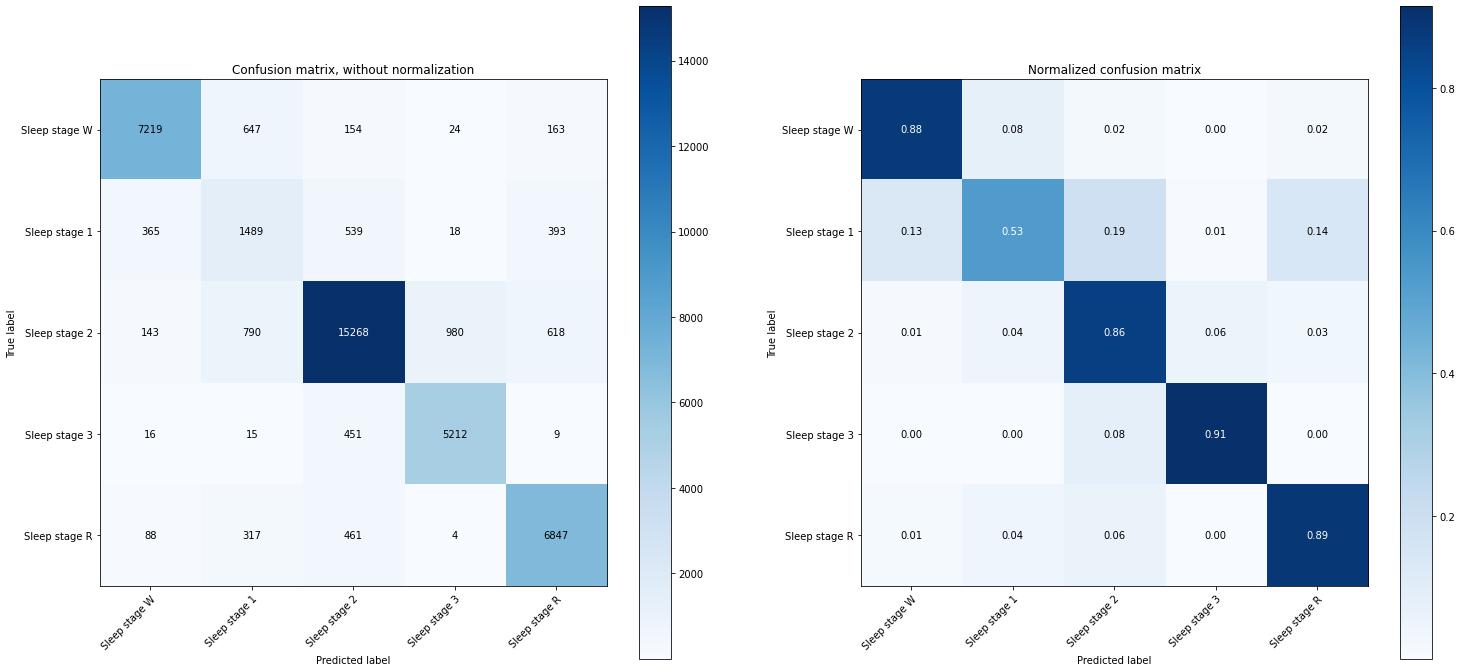





---------------------------------------- ['EEG', 'EMG'] ----------------------------------------
nb. features = 792
10-FOLD: TRAIN
  MACRO F1:           0.8348
  Balanced accuracy:  0.845
  Accuracy:           0.8787
  Log loss:           0.5784
10-FOLD: TEST
  MACRO F1:           0.7792
  Balanced accuracy:  0.803
  Accuracy:           0.8409
  Log loss:           0.8855

F1: 0.7866013011199435
ACC: 0.8421974899360644
KAPPA: 0.7859640629515818
LOG LOSS: 0.8843714567886828

               precision    recall  f1-score   support

Sleep stage 1       0.49      0.40      0.44      3444
Sleep stage 2       0.85      0.91      0.88     16682
Sleep stage 3       0.91      0.84      0.87      6209
Sleep stage R       0.86      0.83      0.84      7952
Sleep stage W       0.88      0.91      0.90      7943

     accuracy                           0.84     42230
    macro avg       0.80      0.78      0.79     42230
 weighted avg       0.84      0.84      0.84     42230



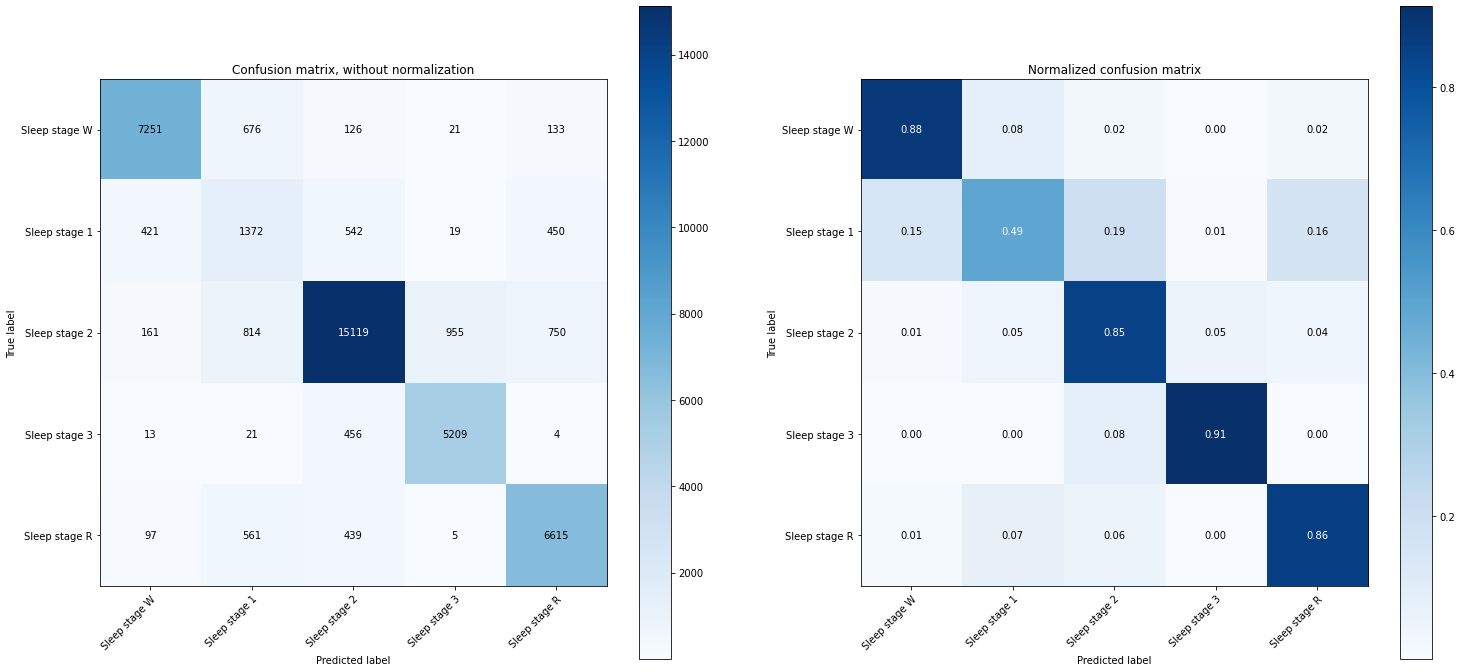

In [22]:
for inputs in [["EEG"], ["EEG", "EOG"], ["EEG", "EMG"]]:
    print("--" * 20, inputs, "--" * 20)

    feats_input = [f for f in feat_cols if f.split(" ")[0] in inputs]
    print("nb. features =", len(feats_input))

    ## Cross-validation
    # Total of 10 folds
    gkfold = StratifiedGroupKFold(n_splits=20)
    cv = gkfold.split(df_feats_sc20, df_feats_sc20["label"], groups=df_feats_sc20.patient_id)

    res = cross_validate(
        pipe,
        df_feats_sc20[feats_input],
        df_feats_sc20["label"],
        scoring=["f1_macro", "balanced_accuracy", "accuracy", "neg_log_loss"],
        cv=cv,
        n_jobs=25,
        return_train_score=True,
        return_estimator=True,
    )

    print("10-FOLD: TRAIN")
    print("  MACRO F1:          ", round(np.mean(res["train_f1_macro"]), 4))
    print("  Balanced accuracy: ", round(np.mean(res["train_balanced_accuracy"]), 4))
    print("  Accuracy:          ", round(np.mean(res["train_accuracy"]), 4))
    print("  Log loss:          ", round(np.mean(-1 * res["train_neg_log_loss"]), 4))

    print("10-FOLD: TEST")
    print("  MACRO F1:          ", round(np.mean(res["test_f1_macro"]), 4))
    print("  Balanced accuracy: ", round(np.mean(res["test_balanced_accuracy"]), 4))
    print("  Accuracy:          ", round(np.mean(res["test_accuracy"]), 4))
    print("  Log loss:          ", round(np.mean(-1 * res["test_neg_log_loss"]), 4))

    preds = []
    preds_proba = []
    y_trues = []
    cv = gkfold.split(df_feats_sc20, df_feats_sc20["label"], groups=df_feats_sc20.patient_id)
    for fold_ix, (train_idx, test_idx) in enumerate(cv):
        X_train = df_feats_sc20[feats_input].iloc[train_idx]
        y_train = df_feats_sc20["label"].iloc[train_idx]
        X_test = df_feats_sc20[feats_input].iloc[test_idx]
        y_test = df_feats_sc20["label"].iloc[test_idx]
        
        estimator = res["estimator"][fold_ix]
        preds += [estimator.predict(X_test)]
        preds_proba += [estimator.predict_proba(X_test)]
        y_trues += [y_test]

    preds = np.hstack(preds)
    y_trues = np.hstack(y_trues)
    preds_proba = np.vstack(preds_proba)

    print()
    print("F1:", f1_score(preds, y_trues, average="macro"))
    print("ACC:", accuracy_score(preds, y_trues))
    print("KAPPA:", cohen_kappa_score(preds, y_trues))
    print("LOG LOSS:", log_loss(y_trues, preds_proba))
    print()

    print(classification_report(preds, y_trues))

    plt.figure(figsize=(25,12))
    ax = plt.subplot(1,2,1)
    plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=False, ax=ax)
    ax = plt.subplot(1,2,2)
    plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=True, ax=ax)
    plt.show()

    print("\n\n\n")

### Grouped 10-fold results for SC-78 for varying inputs

---------------------------------------- ['EEG'] ----------------------------------------
nb. features = 592
10-FOLD: TRAIN
  MACRO F1:           0.7571
  Balanced accuracy:  0.7752
  Accuracy:           0.8138
  Log loss:           0.5614
10-FOLD: TEST
  MACRO F1:           0.7358
  Balanced accuracy:  0.7545
  Accuracy:           0.7967
  Log loss:           0.6504

F1: 0.7375197839651523
ACC: 0.7971491228070176
KAPPA: 0.7231477332127203
LOG LOSS: 0.6489759278558562

               precision    recall  f1-score   support

Sleep stage 1       0.42      0.45      0.43     19921
Sleep stage 2       0.81      0.85      0.83     65593
Sleep stage 3       0.88      0.70      0.78     16412
Sleep stage R       0.77      0.71      0.74     28046
Sleep stage W       0.90      0.91      0.91     65196

     accuracy                           0.80    195168
    macro avg       0.76      0.72      0.74    195168
 weighted avg       0.80      0.80      0.80    195168



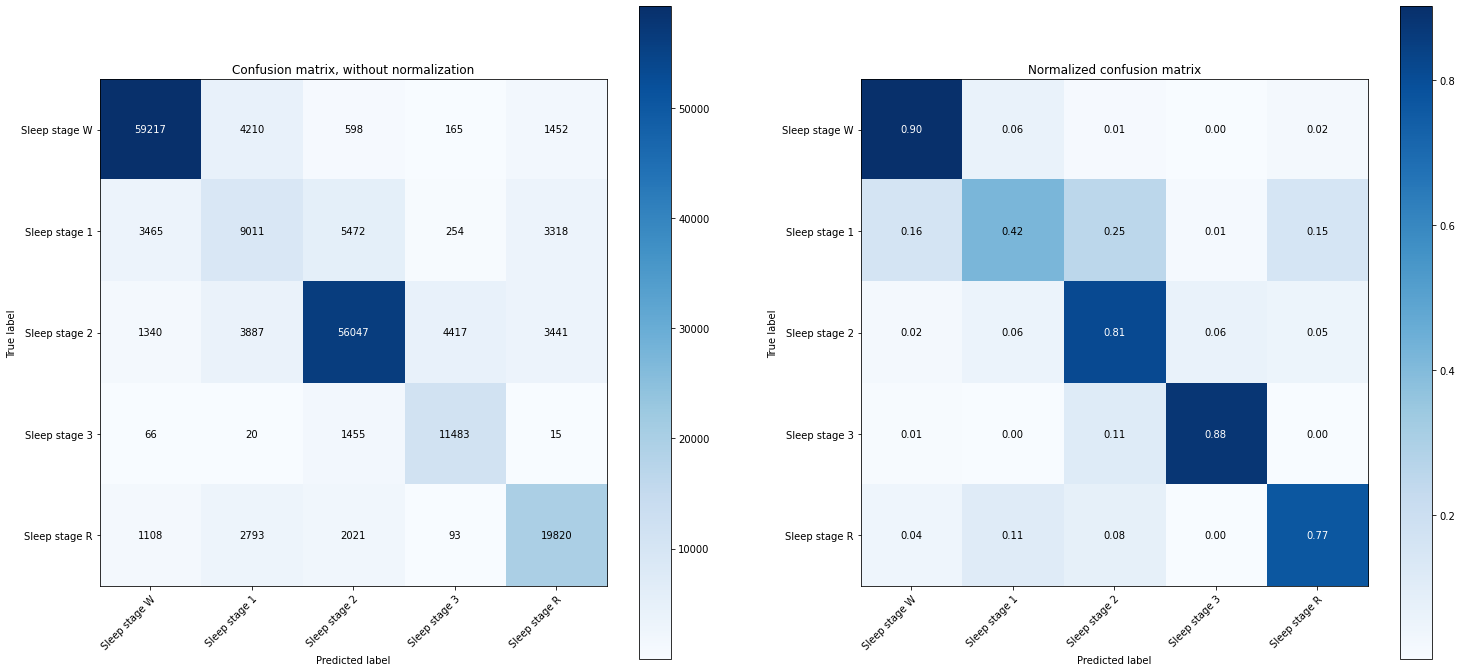





---------------------------------------- ['EEG', 'EOG'] ----------------------------------------
nb. features = 848
10-FOLD: TRAIN
  MACRO F1:           0.7888
  Balanced accuracy:  0.8039
  Accuracy:           0.8369
  Log loss:           0.5305
10-FOLD: TEST
  MACRO F1:           0.7663
  Balanced accuracy:  0.7813
  Accuracy:           0.8194
  Log loss:           0.6307

F1: 0.7679813186080333
ACC: 0.8197399163797344
KAPPA: 0.7534196593245716
LOG LOSS: 0.629502347298955

               precision    recall  f1-score   support

Sleep stage 1       0.48      0.49      0.49     20772
Sleep stage 2       0.83      0.85      0.84     67593
Sleep stage 3       0.87      0.70      0.78     16152
Sleep stage R       0.82      0.82      0.82     26029
Sleep stage W       0.91      0.92      0.91     64622

     accuracy                           0.82    195168
    macro avg       0.78      0.76      0.77    195168
 weighted avg       0.82      0.82      0.82    195168



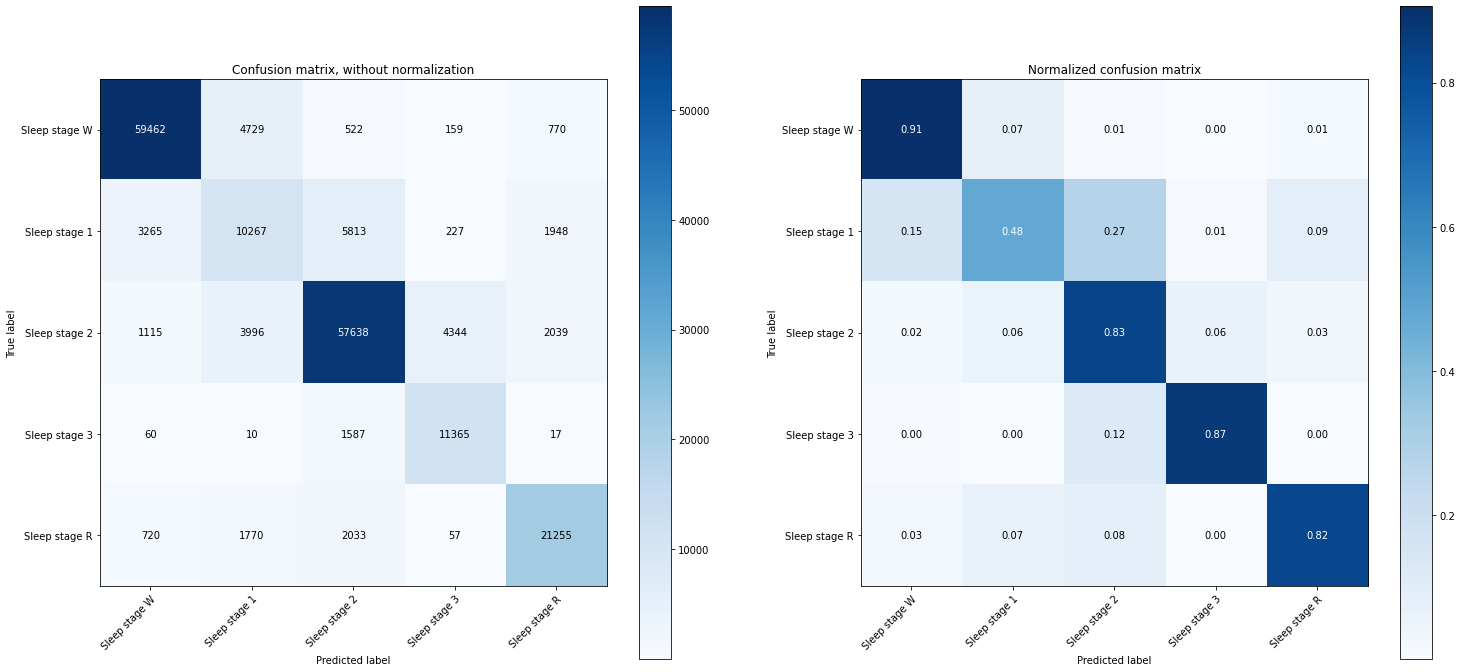





---------------------------------------- ['EEG', 'EMG'] ----------------------------------------
nb. features = 792
10-FOLD: TRAIN
  MACRO F1:           0.7692
  Balanced accuracy:  0.7876
  Accuracy:           0.8204
  Log loss:           0.5642
10-FOLD: TEST
  MACRO F1:           0.744
  Balanced accuracy:  0.7631
  Accuracy:           0.7997
  Log loss:           0.6718

F1: 0.7455073218335284
ACC: 0.8000286932283981
KAPPA: 0.7275502974240338
LOG LOSS: 0.6704580474148089

               precision    recall  f1-score   support

Sleep stage 1       0.46      0.46      0.46     21313
Sleep stage 2       0.80      0.86      0.83     64522
Sleep stage 3       0.88      0.70      0.78     16344
Sleep stage R       0.78      0.73      0.75     27715
Sleep stage W       0.91      0.91      0.91     65274

     accuracy                           0.80    195168
    macro avg       0.76      0.73      0.75    195168
 weighted avg       0.80      0.80      0.80    195168



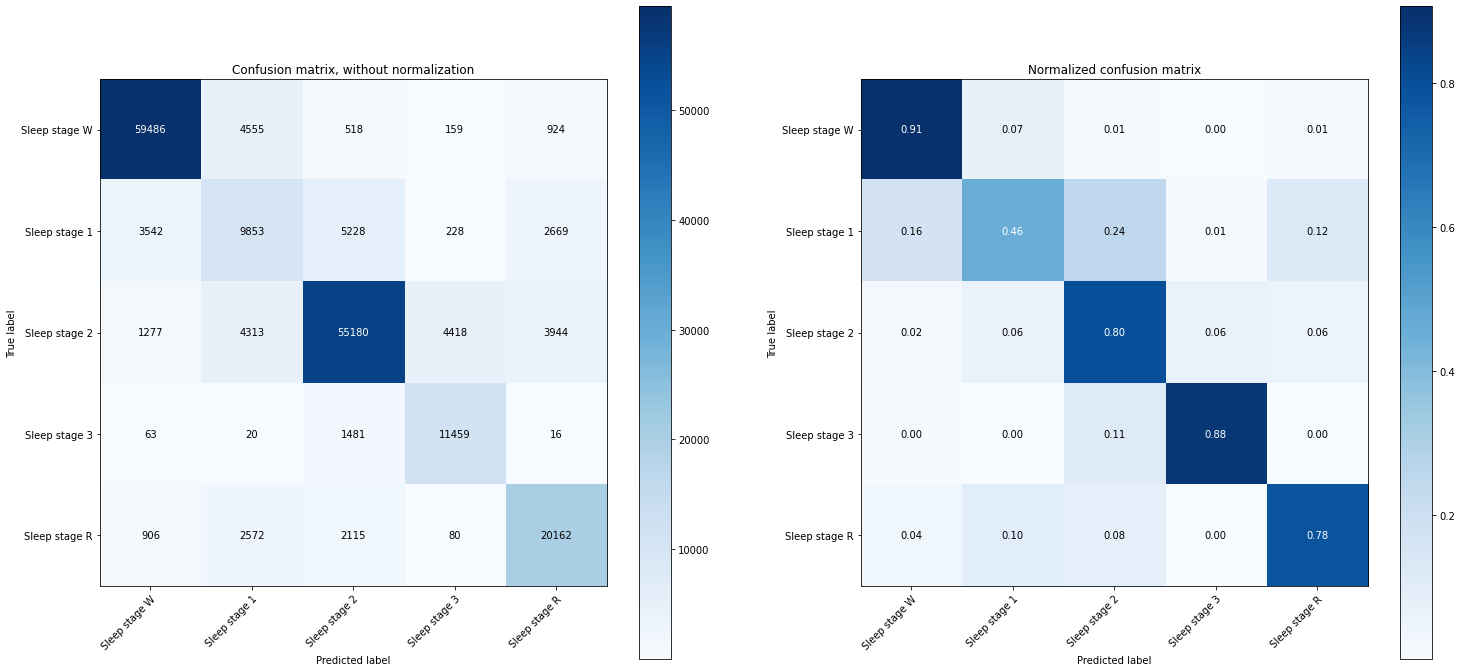

In [23]:
for inputs in [["EEG"], ["EEG", "EOG"], ["EEG", "EMG"]]:
    print("--" * 20, inputs, "--" * 20)

    feats_input = [f for f in feat_cols if f.split(" ")[0] in inputs]
    print("nb. features =", len(feats_input))

    ## Cross-validation
    # Total of 10 folds
    gkfold = StratifiedGroupKFold(n_splits=10)
    cv = gkfold.split(df_feats, df_feats["label"], groups=df_feats.patient_id)

    res = cross_validate(
        pipe,
        df_feats[feats_input],
        df_feats["label"],
        scoring=["f1_macro", "balanced_accuracy", "accuracy", "neg_log_loss"],
        cv=cv,
        n_jobs=25,
        return_train_score=True,
        return_estimator=True,
    )

    print("10-FOLD: TRAIN")
    print("  MACRO F1:          ", round(np.mean(res["train_f1_macro"]), 4))
    print("  Balanced accuracy: ", round(np.mean(res["train_balanced_accuracy"]), 4))
    print("  Accuracy:          ", round(np.mean(res["train_accuracy"]), 4))
    print("  Log loss:          ", round(np.mean(-1 * res["train_neg_log_loss"]), 4))

    print("10-FOLD: TEST")
    print("  MACRO F1:          ", round(np.mean(res["test_f1_macro"]), 4))
    print("  Balanced accuracy: ", round(np.mean(res["test_balanced_accuracy"]), 4))
    print("  Accuracy:          ", round(np.mean(res["test_accuracy"]), 4))
    print("  Log loss:          ", round(np.mean(-1 * res["test_neg_log_loss"]), 4))

    preds = []
    preds_proba = []
    y_trues = []
    cv = gkfold.split(df_feats, df_feats["label"], groups=df_feats.patient_id)
    for fold_ix, (train_idx, test_idx) in enumerate(cv):
        X_train = df_feats[feats_input].iloc[train_idx]
        y_train = df_feats["label"].iloc[train_idx]
        X_test = df_feats[feats_input].iloc[test_idx]
        y_test = df_feats["label"].iloc[test_idx]
        
        estimator = res["estimator"][fold_ix]
        preds += [estimator.predict(X_test)]
        preds_proba += [estimator.predict_proba(X_test)]
        y_trues += [y_test]

    preds = np.hstack(preds)
    y_trues = np.hstack(y_trues)
    preds_proba = np.vstack(preds_proba)

    print()
    print("F1:", f1_score(preds, y_trues, average="macro"))
    print("ACC:", accuracy_score(preds, y_trues))
    print("KAPPA:", cohen_kappa_score(preds, y_trues))
    print("LOG LOSS:", log_loss(y_trues, preds_proba))
    print()

    print(classification_report(preds, y_trues))

    plt.figure(figsize=(25,12))
    ax = plt.subplot(1,2,1)
    plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=False, ax=ax)
    ax = plt.subplot(1,2,2)
    plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=True, ax=ax)
    plt.show()

    print("\n\n\n")

## The simple, catboost pipeline

In [24]:
### Create pipeline
from catboost import CatBoostClassifier
pipe = CatBoostClassifier(verbose=0, depth=5, n_estimators=2_000, random_state=0)

### Grouped 20-fold results for SC-20 for varying inputs

---------------------------------------- ['EEG'] ----------------------------------------
nb. features = 592
10-FOLD: TRAIN
  MACRO F1:           0.9166
  Balanced accuracy:  0.9041
  Accuracy:           0.9396
  Log loss:           0.1864
10-FOLD: TEST
  MACRO F1:           0.7677
  Balanced accuracy:  0.7732
  Accuracy:           0.8439
  Log loss:           0.4245

F1: 0.7720595790809958
ACC: 0.8422211697845133
KAPPA: 0.7822574931585902
LOG LOSS: 0.42826100933913197

               precision    recall  f1-score   support

Sleep stage 1       0.35      0.43      0.38      2304
Sleep stage 2       0.89      0.87      0.88     18260
Sleep stage 3       0.89      0.88      0.89      5729
Sleep stage R       0.82      0.81      0.82      7792
Sleep stage W       0.89      0.89      0.89      8145

     accuracy                           0.84     42230
    macro avg       0.77      0.78      0.77     42230
 weighted avg       0.85      0.84      0.85     42230



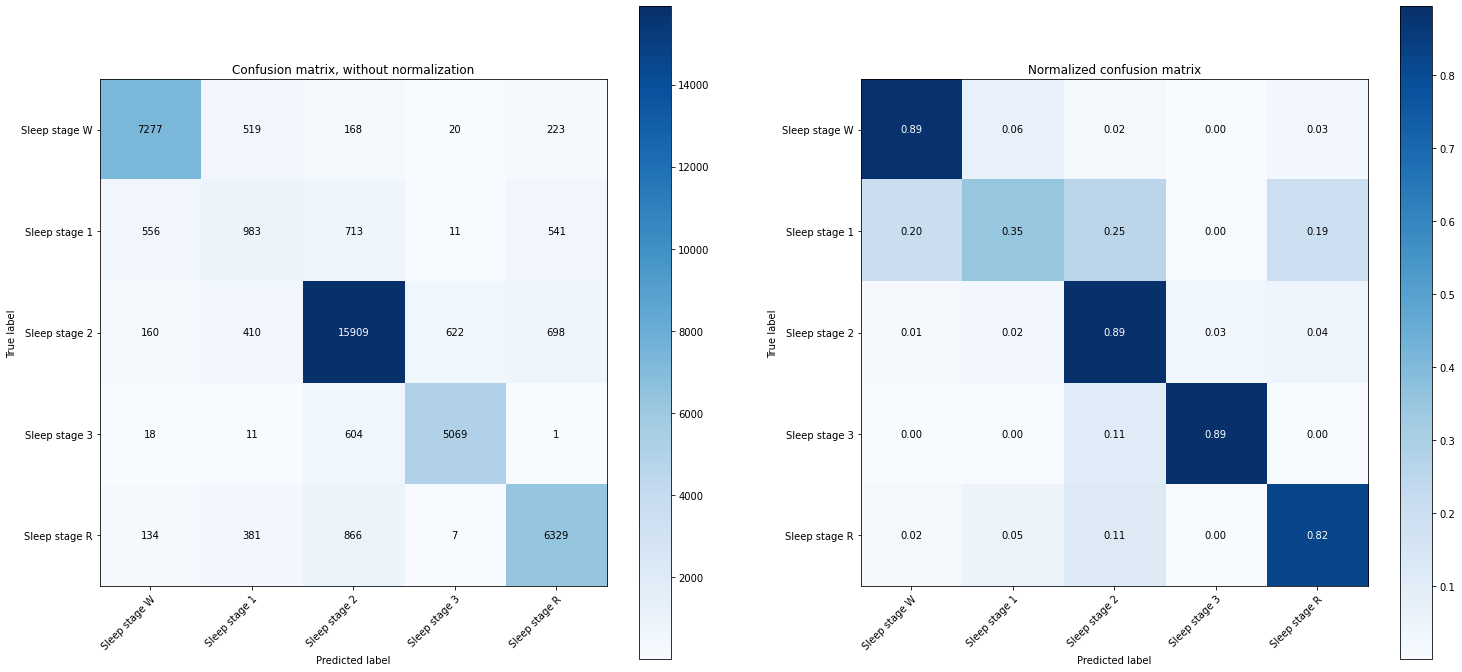





---------------------------------------- ['EEG', 'EOG'] ----------------------------------------
nb. features = 848
10-FOLD: TRAIN
  MACRO F1:           0.9281
  Balanced accuracy:  0.917
  Accuracy:           0.947
  Log loss:           0.1646
10-FOLD: TEST
  MACRO F1:           0.7906
  Balanced accuracy:  0.7967
  Accuracy:           0.8621
  Log loss:           0.3733

F1: 0.7966299329881882
ACC: 0.8600994553634856
KAPPA: 0.8065490001190667
LOG LOSS: 0.37850550835939106

               precision    recall  f1-score   support

Sleep stage 1       0.39      0.53      0.45      2047
Sleep stage 2       0.91      0.88      0.89     18380
Sleep stage 3       0.89      0.89      0.89      5705
Sleep stage R       0.87      0.85      0.86      7898
Sleep stage W       0.89      0.89      0.89      8200

     accuracy                           0.86     42230
    macro avg       0.79      0.81      0.80     42230
 weighted avg       0.87      0.86      0.86     42230



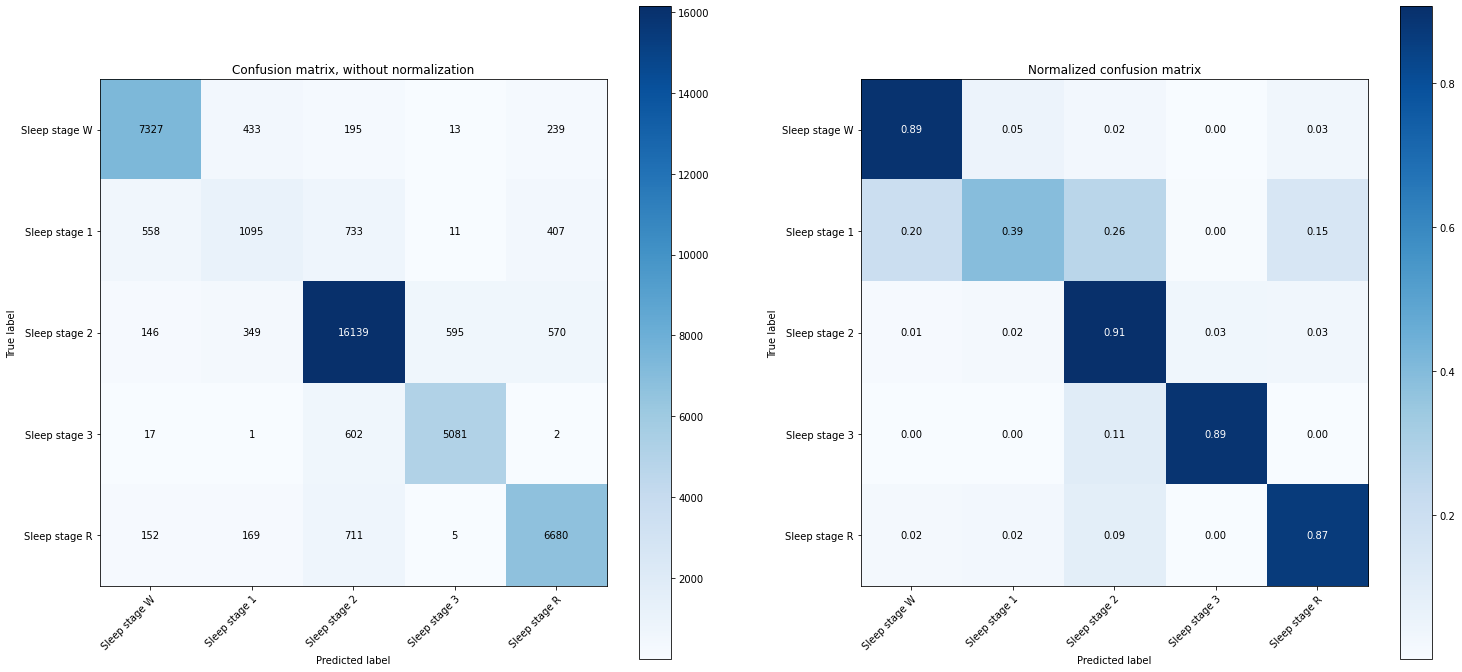





---------------------------------------- ['EEG', 'EMG'] ----------------------------------------
nb. features = 792
10-FOLD: TRAIN
  MACRO F1:           0.9173
  Balanced accuracy:  0.9058
  Accuracy:           0.9397
  Log loss:           0.1832
10-FOLD: TEST
  MACRO F1:           0.7721
  Balanced accuracy:  0.7755
  Accuracy:           0.8426
  Log loss:           0.4217

F1: 0.7740850582737122
ACC: 0.8416765332701871
KAPPA: 0.7816950463276022
LOG LOSS: 0.4239931210856706

               precision    recall  f1-score   support

Sleep stage 1       0.36      0.41      0.39      2458
Sleep stage 2       0.89      0.87      0.88     18227
Sleep stage 3       0.89      0.88      0.89      5759
Sleep stage R       0.81      0.83      0.82      7580
Sleep stage W       0.90      0.90      0.90      8206

     accuracy                           0.84     42230
    macro avg       0.77      0.78      0.77     42230
 weighted avg       0.85      0.84      0.84     42230



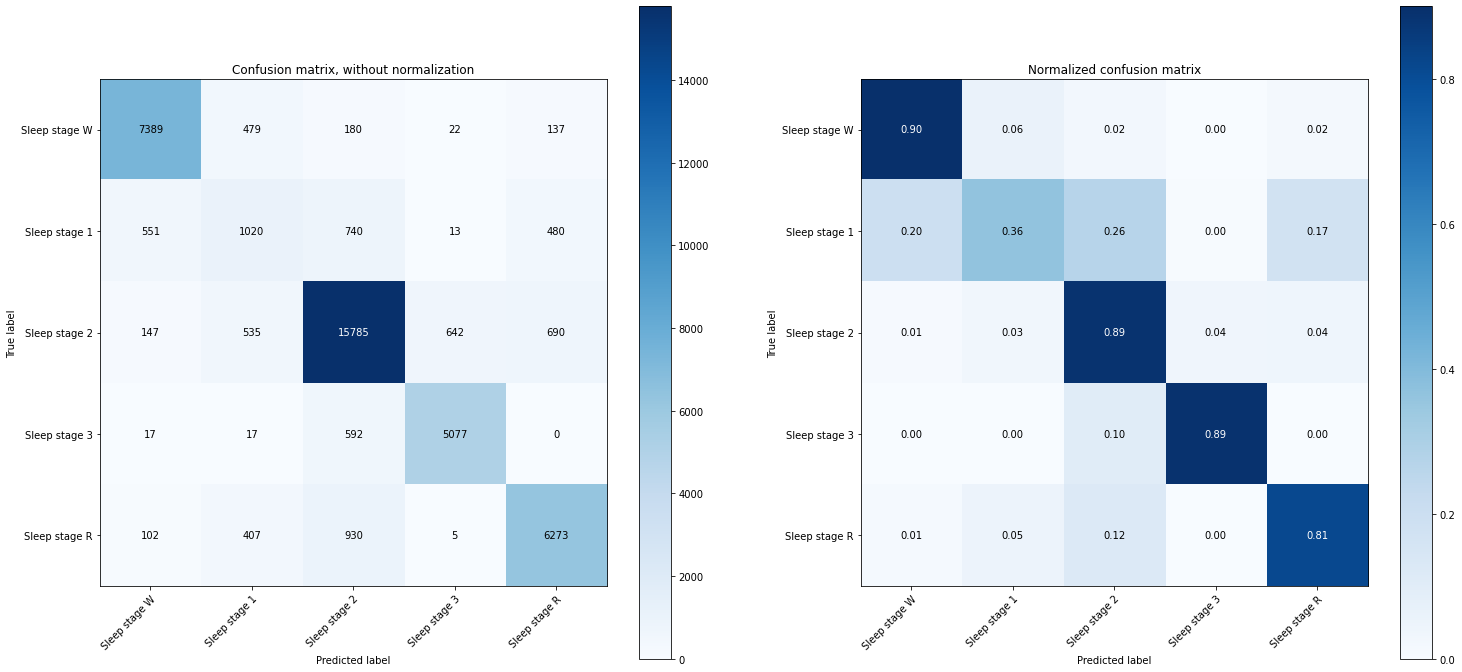

In [25]:
for inputs in [["EEG"], ["EEG", "EOG"], ["EEG", "EMG"]]:
    print("--" * 20, inputs, "--" * 20)

    feats_input = [f for f in feat_cols if f.split(" ")[0] in inputs]
    print("nb. features =", len(feats_input))

    ## Cross-validation
    # Total of 10 folds
    gkfold = StratifiedGroupKFold(n_splits=20)
    cv = gkfold.split(df_feats_sc20, df_feats_sc20["label"], groups=df_feats_sc20.patient_id)

    res = cross_validate(
        pipe,
        df_feats_sc20[feats_input],
        df_feats_sc20["label"],
        scoring=["f1_macro", "balanced_accuracy", "accuracy", "neg_log_loss"],
        cv=cv,
        n_jobs=25,
        return_train_score=True,
        return_estimator=True,
    )

    print("10-FOLD: TRAIN")
    print("  MACRO F1:          ", round(np.mean(res["train_f1_macro"]), 4))
    print("  Balanced accuracy: ", round(np.mean(res["train_balanced_accuracy"]), 4))
    print("  Accuracy:          ", round(np.mean(res["train_accuracy"]), 4))
    print("  Log loss:          ", round(np.mean(-1 * res["train_neg_log_loss"]), 4))

    print("10-FOLD: TEST")
    print("  MACRO F1:          ", round(np.mean(res["test_f1_macro"]), 4))
    print("  Balanced accuracy: ", round(np.mean(res["test_balanced_accuracy"]), 4))
    print("  Accuracy:          ", round(np.mean(res["test_accuracy"]), 4))
    print("  Log loss:          ", round(np.mean(-1 * res["test_neg_log_loss"]), 4))

    preds = []
    preds_proba = []
    y_trues = []
    cv = gkfold.split(df_feats_sc20, df_feats_sc20["label"], groups=df_feats_sc20.patient_id)
    for fold_ix, (train_idx, test_idx) in enumerate(cv):
        X_train = df_feats_sc20[feats_input].iloc[train_idx]
        y_train = df_feats_sc20["label"].iloc[train_idx]
        X_test = df_feats_sc20[feats_input].iloc[test_idx]
        y_test = df_feats_sc20["label"].iloc[test_idx]
        
        estimator = res["estimator"][fold_ix]
        preds += [estimator.predict(X_test).ravel()]
        preds_proba += [estimator.predict_proba(X_test)]
        y_trues += [y_test]

    preds = np.hstack(preds)
    y_trues = np.hstack(y_trues)
    preds_proba = np.vstack(preds_proba)

    print()
    print("F1:", f1_score(preds, y_trues, average="macro"))
    print("ACC:", accuracy_score(preds, y_trues))
    print("KAPPA:", cohen_kappa_score(preds, y_trues))
    print("LOG LOSS:", log_loss(y_trues, preds_proba))
    print()

    print(classification_report(preds, y_trues))

    plt.figure(figsize=(25,12))
    ax = plt.subplot(1,2,1)
    plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=False, ax=ax)
    ax = plt.subplot(1,2,2)
    plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=True, ax=ax)
    plt.show()

    print("\n\n\n")

### Grouped 10-fold results for SC-78 for varying inputs

---------------------------------------- ['EEG'] ----------------------------------------
nb. features = 592
10-FOLD: TRAIN
  MACRO F1:           0.8395
  Balanced accuracy:  0.8286
  Accuracy:           0.8832
  Log loss:           0.3182
10-FOLD: TEST
  MACRO F1:           0.7427
  Balanced accuracy:  0.7355
  Accuracy:           0.81
  Log loss:           0.5011

F1: 0.7447754118807659
ACC: 0.8103172651254305
KAPPA: 0.7361971101180971
LOG LOSS: 0.5003741862040874

               precision    recall  f1-score   support

Sleep stage 1       0.36      0.49      0.42     16118
Sleep stage 2       0.87      0.82      0.84     73491
Sleep stage 3       0.79      0.84      0.82     12159
Sleep stage R       0.73      0.74      0.73     25491
Sleep stage W       0.93      0.90      0.91     67909

     accuracy                           0.81    195168
    macro avg       0.74      0.76      0.74    195168
 weighted avg       0.83      0.81      0.82    195168



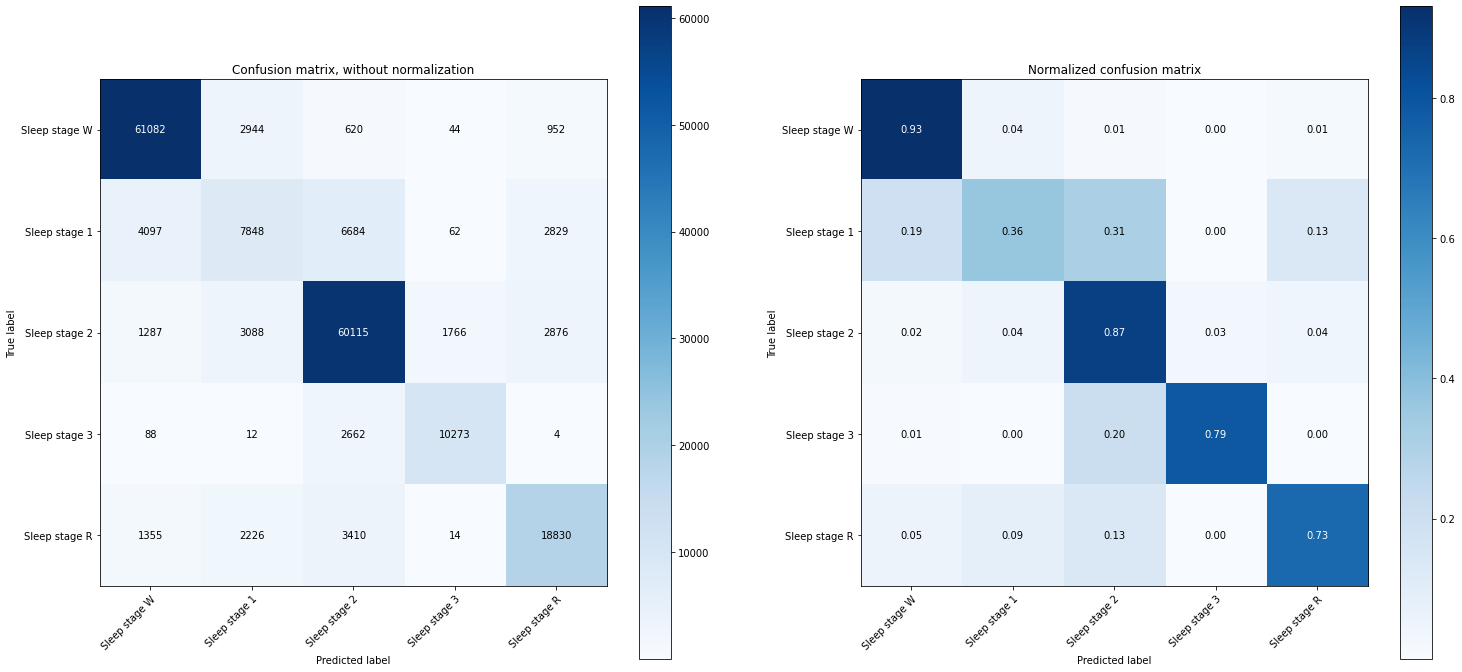





---------------------------------------- ['EEG', 'EOG'] ----------------------------------------
nb. features = 848
10-FOLD: TRAIN
  MACRO F1:           0.8573
  Balanced accuracy:  0.8452
  Accuracy:           0.895
  Log loss:           0.2809
10-FOLD: TEST
  MACRO F1:           0.7704
  Balanced accuracy:  0.7606
  Accuracy:           0.8296
  Log loss:           0.4459

F1: 0.7718524115986305
ACC: 0.8297466797835711
KAPPA: 0.7631852329528094
LOG LOSS: 0.44554553722520857

               precision    recall  f1-score   support

Sleep stage 1       0.41      0.52      0.46     16979
Sleep stage 2       0.89      0.82      0.85     74363
Sleep stage 3       0.78      0.84      0.81     12121
Sleep stage R       0.80      0.84      0.82     24566
Sleep stage W       0.93      0.91      0.92     67139

     accuracy                           0.83    195168
    macro avg       0.76      0.79      0.77    195168
 weighted avg       0.84      0.83      0.83    195168



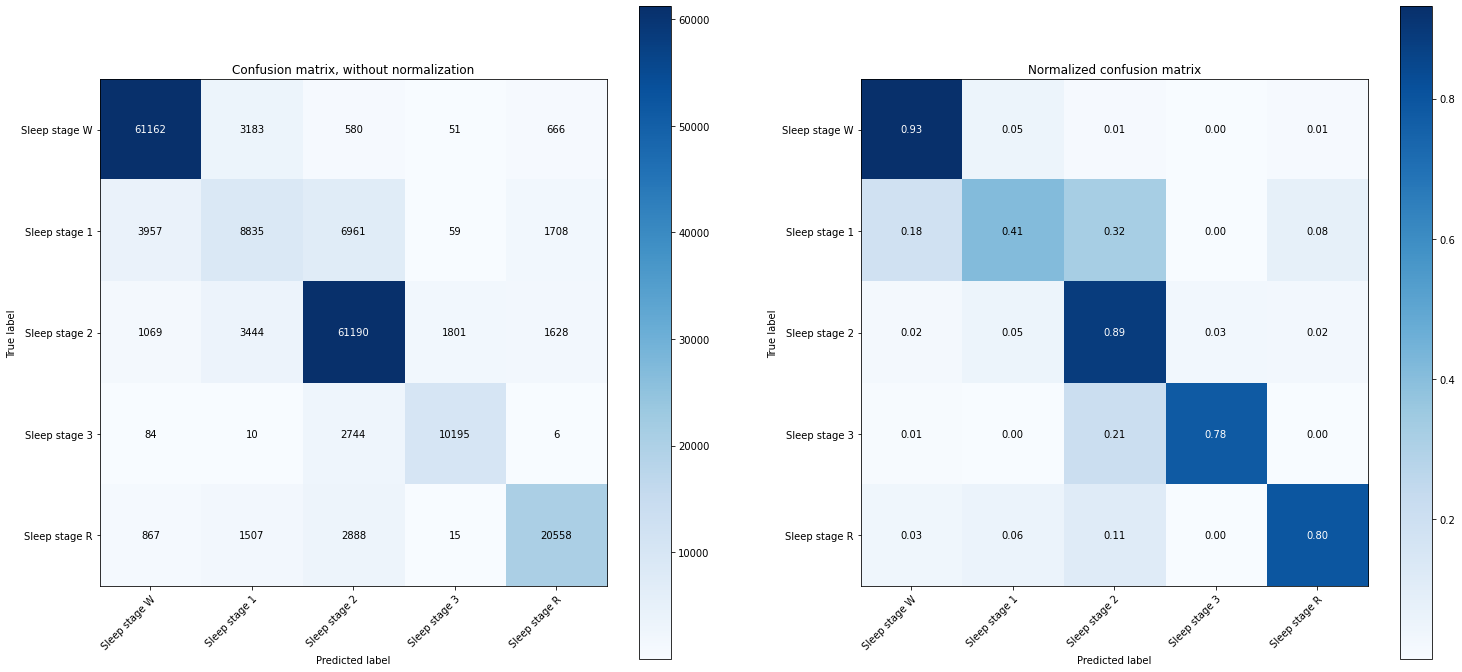





---------------------------------------- ['EEG', 'EMG'] ----------------------------------------
nb. features = 792
10-FOLD: TRAIN
  MACRO F1:           0.8485
  Balanced accuracy:  0.8374
  Accuracy:           0.8888
  Log loss:           0.3032
10-FOLD: TEST
  MACRO F1:           0.7484
  Balanced accuracy:  0.7419
  Accuracy:           0.8131
  Log loss:           0.4872

F1: 0.7504535364838775
ACC: 0.8133864158058698
KAPPA: 0.740804116353312
LOG LOSS: 0.4864675810992214

               precision    recall  f1-score   support

Sleep stage 1       0.39      0.49      0.43     16877
Sleep stage 2       0.86      0.82      0.84     72940
Sleep stage 3       0.79      0.83      0.81     12374
Sleep stage R       0.74      0.76      0.75     25216
Sleep stage W       0.93      0.90      0.92     67761

     accuracy                           0.81    195168
    macro avg       0.74      0.76      0.75    195168
 weighted avg       0.83      0.81      0.82    195168



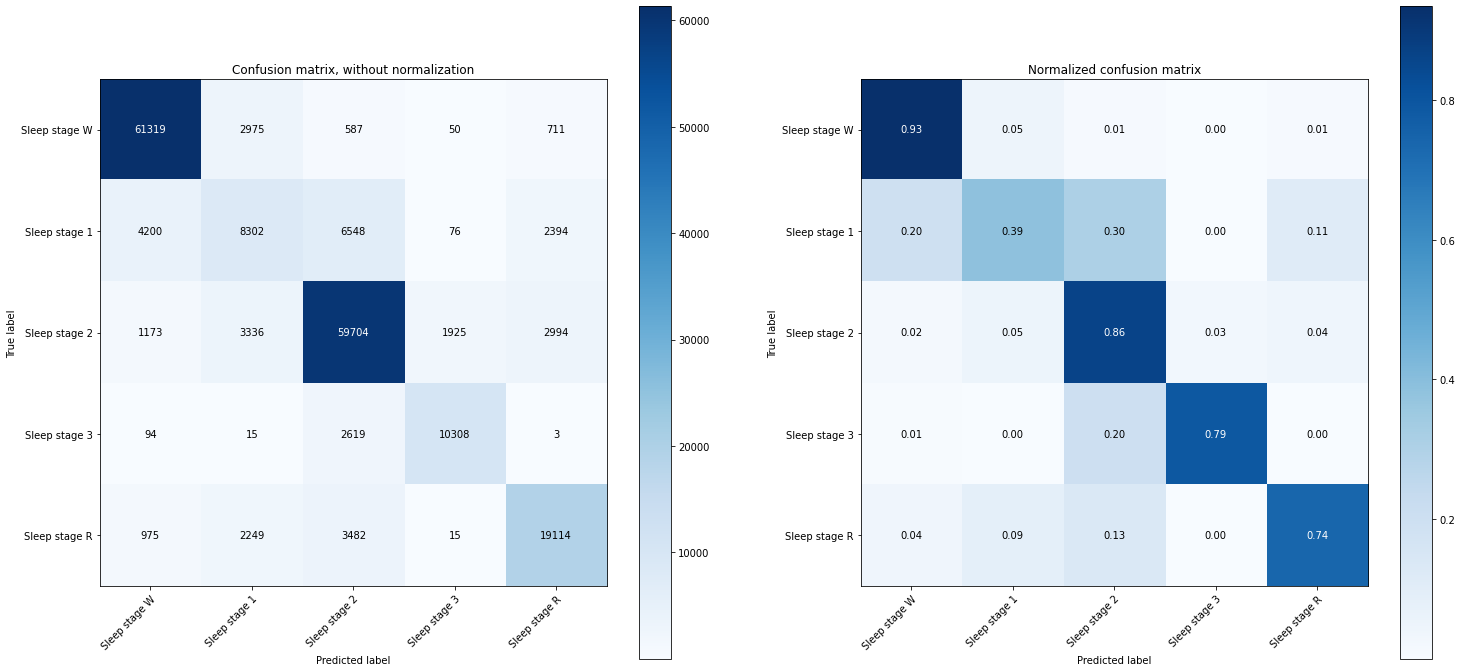

In [26]:
for inputs in [["EEG"], ["EEG", "EOG"], ["EEG", "EMG"]]:
    print("--" * 20, inputs, "--" * 20)

    feats_input = [f for f in feat_cols if f.split(" ")[0] in inputs]
    print("nb. features =", len(feats_input))

    ## Cross-validation
    # Total of 10 folds
    gkfold = StratifiedGroupKFold(n_splits=10)
    cv = gkfold.split(df_feats, df_feats["label"], groups=df_feats.patient_id)

    res = cross_validate(
        pipe,
        df_feats[feats_input],
        df_feats["label"],
        scoring=["f1_macro", "balanced_accuracy", "accuracy", "neg_log_loss"],
        cv=cv,
        n_jobs=25,
        return_train_score=True,
        return_estimator=True,
    )

    print("10-FOLD: TRAIN")
    print("  MACRO F1:          ", round(np.mean(res["train_f1_macro"]), 4))
    print("  Balanced accuracy: ", round(np.mean(res["train_balanced_accuracy"]), 4))
    print("  Accuracy:          ", round(np.mean(res["train_accuracy"]), 4))
    print("  Log loss:          ", round(np.mean(-1 * res["train_neg_log_loss"]), 4))

    print("10-FOLD: TEST")
    print("  MACRO F1:          ", round(np.mean(res["test_f1_macro"]), 4))
    print("  Balanced accuracy: ", round(np.mean(res["test_balanced_accuracy"]), 4))
    print("  Accuracy:          ", round(np.mean(res["test_accuracy"]), 4))
    print("  Log loss:          ", round(np.mean(-1 * res["test_neg_log_loss"]), 4))

    preds = []
    preds_proba = []
    y_trues = []
    cv = gkfold.split(df_feats, df_feats["label"], groups=df_feats.patient_id)
    for fold_ix, (train_idx, test_idx) in enumerate(cv):
        X_train = df_feats[feats_input].iloc[train_idx]
        y_train = df_feats["label"].iloc[train_idx]
        X_test = df_feats[feats_input].iloc[test_idx]
        y_test = df_feats["label"].iloc[test_idx]
        
        estimator = res["estimator"][fold_ix]
        preds += [estimator.predict(X_test).ravel()]
        preds_proba += [estimator.predict_proba(X_test)]
        y_trues += [y_test]

    preds = np.hstack(preds)
    y_trues = np.hstack(y_trues)
    preds_proba = np.vstack(preds_proba)

    print()
    print("F1:", f1_score(preds, y_trues, average="macro"))
    print("ACC:", accuracy_score(preds, y_trues))
    print("KAPPA:", cohen_kappa_score(preds, y_trues))
    print("LOG LOSS:", log_loss(y_trues, preds_proba))
    print()

    print(classification_report(preds, y_trues))

    plt.figure(figsize=(25,12))
    ax = plt.subplot(1,2,1)
    plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=False, ax=ax)
    ax = plt.subplot(1,2,2)
    plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=True, ax=ax)
    plt.show()

    print("\n\n\n")